# HiClass baseline

In [1]:
import os
os.chdir("/home/app/src")

In [2]:
import pandas as pd
import numpy as np
import text_normalizer
import hiclass.metrics
from sklearn import metrics
from scripts.build_df import build_df
from scripts.decode_id import decode_id
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from os import cpu_count
from hiclass import LocalClassifierPerNode, LocalClassifierPerParentNode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scripts.custom_hiclass import CustomLocalClassifierPerParentNode

[nltk_data] Downloading package stopwords to /home/app/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
no_threshold_df = build_df(json_path='data/products.json', threshold=0) 

In [4]:
# df = build_df(json_path='data/products.json', threshold=100)

In [5]:
def normalization(input):
    output = text_normalizer.normalize_corpus(
        input,
        html_stripping=True,
        contraction_expansion=True,
        accented_char_removal=True,
        text_lower_case=True,
        text_stemming=True,
        text_lemmatization=False,
        special_char_removal=True,
        remove_digits=False,
        stopword_removal=True,
        stopwords=text_normalizer.stopword_list
    )       
    return output

In [6]:
X = no_threshold_df['name'].copy()
X = normalization(X.apply(str))
y = no_threshold_df['path'].copy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, 
    random_state=42,
)

In [8]:
tfid_vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
X_train = tfid_vectorizer.fit_transform(X_train)
X_test = tfid_vectorizer.transform(X_test)

### Hierarchical classification

In [10]:
# Initialize model
random_forest = RandomForestClassifier(n_estimators = 500, n_jobs=cpu_count(), random_state=42)
# Initialize hierarchical classifier with model
hierarchical_classifier = CustomLocalClassifierPerParentNode(n_jobs=cpu_count(), local_classifier=random_forest)
# Train hierarchical classifier
hierarchical_classifier.fit(X_train, y_train)

/home/app/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [36]:
# Predict on train and test
# y_pred_train = hierarchical_classifier.predict_5(X_train)[0]
y_pred_test_tot = hierarchical_classifier.predict_5(X_test)
y_pred_test = y_pred_test_tot[0]

In [37]:
# Print standard results
# print("Train")
# print("Precision:", hiclass.metrics.precision(y_train, y_pred_train))
# print("Recall:", hiclass.metrics.recall(y_train, y_pred_train))
# print("F1:", hiclass.metrics.f1(y_train, y_pred_train))
print("\nTest")
print("Precision:", hiclass.metrics.precision(y_test, y_pred_test))
print("Recall:", hiclass.metrics.recall(y_test, y_pred_test))
print("F1:", hiclass.metrics.f1(y_test, y_pred_test))


Test
Precision: 0.8364823526387496
Recall: 0.9007113793007999
F1: 0.8674095004531641


In [ ]:
# Train
# Precision: 0.9327810512045052
# Recall: 0.9968446128555906
# F1: 0.9637493770792086

# Test
# Precision: 0.8365809768637532
# Recall: 0.9007944196861073
# F1: 0.8675010329614671
# Total failures: 500 of 10330

### Analyze predictions

In [53]:
# Base DataFrame
test_df = pd.DataFrame(y_test)
# Add prediction column respecting original index
test_df["prediction_0"] = pd.Series(y_pred_test_tot[0].tolist(), index = test_df.index)
test_df["prediction_1"] = pd.Series(y_pred_test_tot[1].tolist(), index = test_df.index)

# Auxiliary function for creating new columns
def assign_precision(x):
    return hiclass.metrics.precision(x[0:1], x[1:2])
def assign_recall(x):
    return hiclass.metrics.recall(x[0:1], x[1:2])
def assign_f1(x):
    # Condition to avoid ZeroDivisionError
    if x["precision"] * x["recall"] == 0.0:
        return 0.0
    else:
        return 2 * x["precision"] * x["recall"] / (x["precision"] + x["recall"])

# Creat new metrics columns 
test_df["precision"] = test_df.apply(lambda x: assign_precision(x), axis=1)
test_df["recall"] = test_df.apply(lambda x: assign_recall(x), axis=1)
test_df["f1"] = test_df.apply(lambda x: assign_f1(x), axis=1)

In [54]:
test_df.head()

,path,prediction_0,prediction_1,precision,recall,f1
13005,"[pcmcat312300050015, pcmcat248700050021, pcmca...","[pcmcat312300050015, pcmcat248700050021, pcmca...","[abcat0900000, abcat0912000, abcat0912025, pcm...",1.00,1.00,1.00
36568,"[abcat0207000, pcmcat152100050020, pcmcat20570...","[abcat0207000, pcmcat152100050035, pcmcat25160...","[abcat0400000, abcat0410022, pcmcat25800005001...",0.25,0.25,0.25
20664,"[abcat0500000, pcmcat209000050006, pcmcat20900...","[abcat0500000, pcmcat209000050006, pcmcat20900...","[abcat0207000, abcat0208024, pcmcat15160005004...",1.00,1.00,1.00
40271,"[abcat0900000, abcat0912000, pcmcat36740005000...","[abcat0900000, abcat0912000, pcmcat36740005000...","[pcmcat312300050015, pcmcat248700050021, pcmca...",1.00,1.00,1.00
5865,"[abcat0300000, pcmcat165900050023, pcmcat33160...","[abcat0300000, pcmcat165900050023, pcmcat33160...","[pcmcat312300050015, pcmcat254000050002, pcmca...",1.00,1.00,1.00


In [55]:
print("Total failures:", len(test_df["f1"][test_df["f1"] == 0.0]), "of", len(test_df))
test_df["f1"][test_df["f1"] == 0.0]

Total failures: 501 of 10330


13167    0.0
49777    0.0
11541    0.0
664      0.0
49286    0.0
        ... 
32338    0.0
38585    0.0
30674    0.0
51294    0.0
33942    0.0
Name: f1, Length: 501, dtype: float64

In [56]:
def print_path_metrics(index, df_):
    print("Product name:", no_threshold_df["name"].loc[index])
    print(f"Product description:\n{no_threshold_df['description'].loc[index]}\n")
    print("Threshold path:", decode_id(df_["path"].loc[index]))
    print("Predicted path:", decode_id(df_["prediction_0"].loc[index]))
    print("Predicted_1 path:", decode_id(df_["prediction_1"].loc[index]))
    print("\nMetrics (on threshold and predicted path)")
    print("Precision:", df_["precision"].loc[index])
    print("Recall:", df_["recall"].loc[index])
    print("F1:", df_["f1"].loc[index])

### Correct prediction

In [57]:
print_path_metrics(13005, test_df)

Product name: Hanover - Strathmere Outdoor Luxury Wicker Chaise Lounge - Crimson Red
Product description:
HANOVER Strathmere Outdoor Luxury Wicker Chaise Lounge: Hand-woven wicker base; heavy-gauge, rust-resistant steel frame; all-weather olefin fabric; extra-long cushion; adjustable back positioning; includes pillow

Threshold path: ['Connected Home & Housewares', 'Housewares', 'Outdoor Living', 'Patio Furniture & Decor', 'Outdoor Seating', 'Outdoor Lounge Chairs']
Predicted path: ['Connected Home & Housewares', 'Housewares', 'Outdoor Living', 'Patio Furniture & Decor', 'Outdoor Seating', 'Outdoor Lounge Chairs', '']
Predicted_1 path: ['Appliances', 'Small Kitchen Appliances', 'Kitchen Gadgets', 'Food Preparation Utensils', '', '', '']

Metrics (on threshold and predicted path)
Precision: 1.0
Recall: 1.0
F1: 1.0


### Kind of correct prediction

In [58]:
print_path_metrics(47899, test_df)

Product name: MartinLogan - Dynamo 15" 650W Powered Subwoofer - Gloss Black
Product description:
1300W peak power; 15" high-excursion polypropylene woofer cone in cast-aluminum basket; ceramic magnet; adjustable front- or down-firing configuration; L/R LFE RCA line-level, LFE XLR and 12V trigger inputs

Threshold path: ['Audio', 'Home Audio', 'Speakers', 'Subwoofer Speakers']
Predicted path: ['Audio', 'Home Audio', 'Speakers', 'Subwoofer Speakers', '', '', '']
Predicted_1 path: ['Car Electronics & GPS', 'Car Audio', 'Car Subwoofers & Enclosures', 'Car Subwoofers', '', '', '']

Metrics (on threshold and predicted path)
Precision: 1.0
Recall: 1.0
F1: 1.0


In [59]:
print_path_metrics(4702, test_df)

Product name: Elite Cuisine - 2-in-1 Dual-Function Breakfast Station
Product description:
2-slice toaster with 7-shade variable browning control, cancel/stop button and slide-out crumb tray; single-serve coffeemaker with removable, washable filter; cool-touch body; antislip rubber feet

Threshold path: ['Appliances', 'Small Kitchen Appliances', 'Toasters']
Predicted path: ['Appliances', 'Small Kitchen Appliances', 'Electric Griddles & Hotplates', '', '', '', '']
Predicted_1 path: ['Health, Fitness & Beauty', 'Personal Care & Beauty', 'Shavers & Trimmers', 'Trimmers', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1: 0.6666666666666666


### Complete failures 

In [60]:
print("Total failures:", len(test_df["f1"][test_df["f1"] == 0.0]), "of", len(test_df))
test_df["f1"][test_df["f1"] == 0.0]

Total failures: 501 of 10330


13167    0.0
49777    0.0
11541    0.0
664      0.0
49286    0.0
        ... 
32338    0.0
38585    0.0
30674    0.0
51294    0.0
33942    0.0
Name: f1, Length: 501, dtype: float64

#### Failures (?)

In [61]:
print_path_metrics(49777, test_df)

Product name: Apple - Optical Mouse - White
Product description:
Force-sensing side buttons; scroll ball; optical technology; touch-sensitive top shell

Threshold path: ['Name Brands', 'Apple', 'Accessories']
Predicted path: ['Computers & Tablets', 'Computer Accessories & Peripherals', 'Mice & Keyboards', 'Mice', 'Wireless & Bluetooth Mice', '', '']
Predicted_1 path: ['Cell Phones', 'Cell Phone Accessories', 'Adapters, Cables & Chargers', 'Car Chargers', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [62]:
print_path_metrics(11541, test_df)

Product name: Serta - RTA Santa Cruz Collection 61" Fabric Loveseat Sofa - Beige
Product description:
SERTA RTA Santa Cruz Collection 61" Fabric Loveseat Sofa: Hardwood frame with polyester fabric upholstery; accommodates 2 people; rich espresso finish on the wood and plastic footers; includes 2 accent pillows

Threshold path: ['Magnolia Home Theater', 'Magnolia Accessories', 'Magnolia TV Stands, Mounts & Furniture']
Predicted path: ['Connected Home & Housewares', 'Furniture & Decor', 'Living Room Furniture', 'Sofas & Sectionals', 'Sofas', '', '']
Predicted_1 path: ['Magnolia Home Theater', 'Magnolia Accessories', 'Magnolia TV Stands, Mounts & Furniture', '', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [63]:
print_path_metrics(31535, test_df)

Product name: JOBY - GripTight GorillaPod Magnetic XL Tripod for Select Cell Phones
Product description:
Compatible with most cell phones; magnetic feet; flexible legs

Threshold path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Tripods & Monopods', 'Camera Mounts']
Predicted path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Tripods & Monopods', 'Tripods', '', '', '']
Predicted_1 path: ['Cell Phones', 'Cell Phone Accessories', 'Cell Phone Cases & Clips', 'Fitted', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.75
Recall: 0.75
F1: 0.75


#### Failures

In [64]:
print_path_metrics(13167, test_df)

Product name: FLIR - Sport Case and Mount for FLIR FX Cameras - Transparent
Product description:
FLIR Sport Case and Mount for FLIR FX Cameras: Compatible with most FLIR FX cameras; works with most 1/4"-20 mounting devices; waterproof

Threshold path: ['Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Camera & System Accessories', 'Surveillance Camera Mounts']
Predicted path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Camera Bags, Cases & Straps', 'Camera Bags & Cases', 'Universal Camera Bags & Cases', '', '']
Predicted_1 path: ['Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Cameras', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [65]:
print_path_metrics(24334, test_df)

Product name: SteelSeries - Siberia Prism 150 Gaming Headset - Black
Product description:
SteelSeries Engine 3 technology; ColorShift technology; integrated volume control; chat capability

Threshold path: ['Name Brands', 'SteelSeries', 'SteelSeries Headsets']
Predicted path: ['Name Brands', 'SteelSeries', 'SteelSeries Mice', '', '', '', '']
Predicted_1 path: ['Video Games', 'Video Game Accessories', 'Gaming Headsets', '', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1: 0.6666666666666666


In [66]:
print_path_metrics(13167, test_df)

Product name: FLIR - Sport Case and Mount for FLIR FX Cameras - Transparent
Product description:
FLIR Sport Case and Mount for FLIR FX Cameras: Compatible with most FLIR FX cameras; works with most 1/4"-20 mounting devices; waterproof

Threshold path: ['Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Camera & System Accessories', 'Surveillance Camera Mounts']
Predicted path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Camera Bags, Cases & Straps', 'Camera Bags & Cases', 'Universal Camera Bags & Cases', '', '']
Predicted_1 path: ['Connected Home & Housewares', 'Connected Home', 'Security Cameras & Surveillance', 'Security Cameras', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


In [67]:
print_path_metrics(51294, test_df)

Product name: Lenmar - Notebook Battery - Black
Product description:
Proprietary2200mAh - 11.1V DC

Threshold path: ['Computers & Tablets', 'Computer Accessories & Peripherals', 'Laptop Accessories', 'Laptop Batteries']
Predicted path: ['Cameras & Camcorders', 'Digital Camera Accessories', 'Camera Batteries & Power', 'Camera Batteries', 'DSLR Camera Batteries', '', '']
Predicted_1 path: ['Cell Phones', 'Cell Phone Accessories', 'Cell Phone Batteries & Power', 'Internal Batteries', '', '', '']

Metrics (on threshold and predicted path)
Precision: 0.0
Recall: 0.0
F1: 0.0


#### Plots

<AxesSubplot:xlabel='f1', ylabel='Percent'>

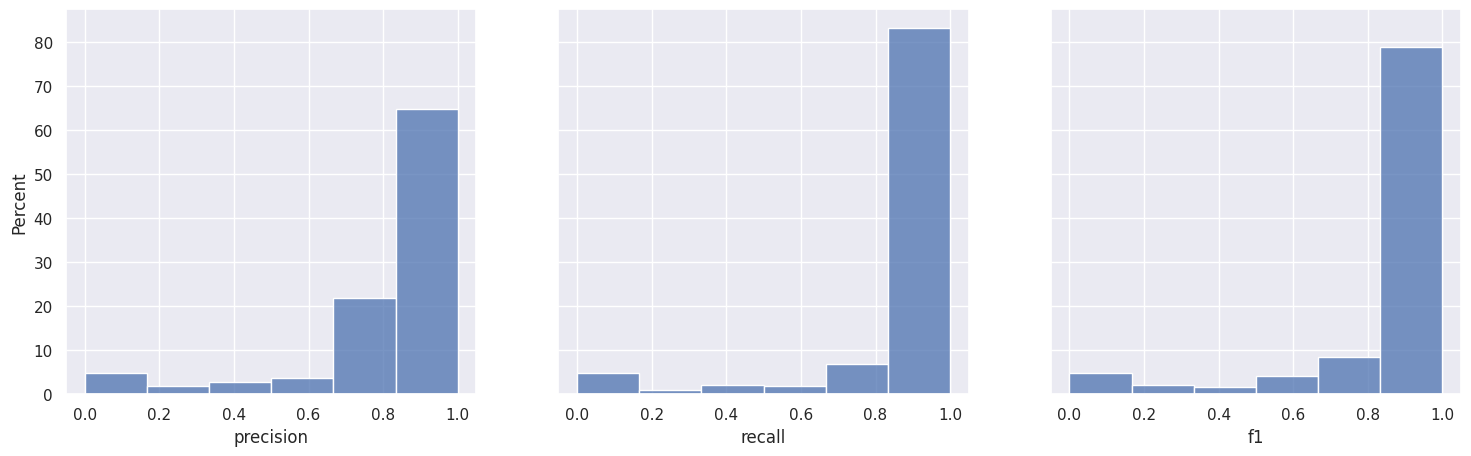

In [ ]:
sns.set()
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)
sns.histplot(test_df["precision"], stat="percent", ax=axes[0], bins=6)
sns.histplot(test_df["recall"], stat="percent",ax=axes[1], bins=6)
sns.histplot(test_df["f1"], stat="percent",ax=axes[2], bins=6)

#### Predict on new data

In [71]:
string_to_predict = "2-slice toaster with 7-shade variable browning control, cancel/stop button and slide-out crumb tray; single-serve coffeemaker with removable, washable filter; cool-touch body; antislip rubber feet"
decode_id(hierarchical_classifier.predict(tfid_vectorizer.transform(normalization(pd.Series(string_to_predict)))).tolist()[0])

['Appliances', 'Small Kitchen Appliances', 'Toasters', '', '', '', '']